# Implementing a Perceptron Algorithm

## Abstract

<!-- Link to [perceptron source code](https://github.com/EpicET/EpicET.github.io/blob/main/posts/blog4/perceptron.py). -->

This blog post explores the implementation and behavior of the perceptron algorithm. Using PyTorch, I implement perecepton grad and optimizing functionality. I analyze how the perceptron performs under different scenarios: linearly separable data, non-linearly separable data, and high-dimensional inputs. The goal is to observe how the perceptron learns from data and how its performance is affected by noise, dimensionality, and training strategies such as stochastic and mini-batch updates.

The grad function in the Perceptron class computes the weight update for the model, adapting to either standard (single-point) or mini-batch training. When mini_batch is set to False, the function performs the normal perceptron update using only one data point. It checks if the point is misclassified by evaluating whether the score times the modified label (in {-1, 1}) is less than zero. If so, it returns a weight adjustment in the direction of the mislabeled point; otherwise, the update is zero. In the mini-batch case (mini_batch=True), the function processes a batch of samples. It first computes the scores for all examples, identifies which ones are misclassified, and then calculates a weighted sum of their feature vectors scaled by the learning rate alpha. This update is averaged over the batch size to maintain stability. The result is a single update vector that shifts the decision boundary based on all misclassified points in the batch.

In [ ]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

Cells 1 to 7 has been directly adapted from Prof. Phil's code. Cell 8 is slightly modified from the original code.
The code below in the sets up the necessary functions to implement a perceptron algorithm.

In [2]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    
    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X: torch.Tensor, y: torch.Tensor, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

def draw_line(w: torch.Tensor, x_min: int, x_max: int, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)


### Test the Perceptron Algorithm
This tests the Perceptron to see if the loss does reach 0.

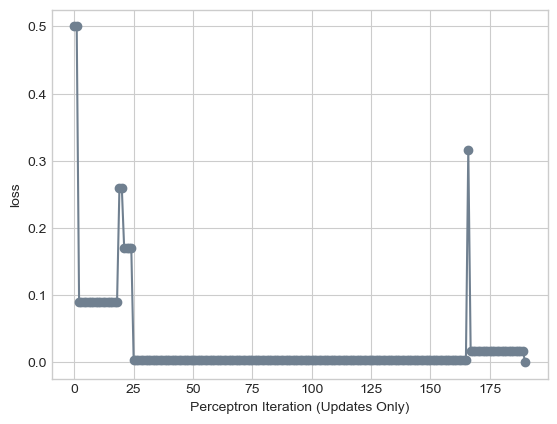

In [3]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

The plot shows the perceptron loss decreasing over 180 update iterations. Initially, the loss is high (\~0.5), but it drops sharply within the first 30 updates, indicating rapid correction of misclassified points. Occasional spikes (e.g., near iterations 20 and 170) reflect temporary misclassifications due to stochastic updates. Despite these, the overall trend is downward, and the loss reaches zero around iteration 180, confirming that the data is linearly separable and the perceptron successfully learned a perfect decision boundary.


## Experiment 1
This plots the decision boundary and the data points over time.

Ran out of axes to plot. Stopping early.


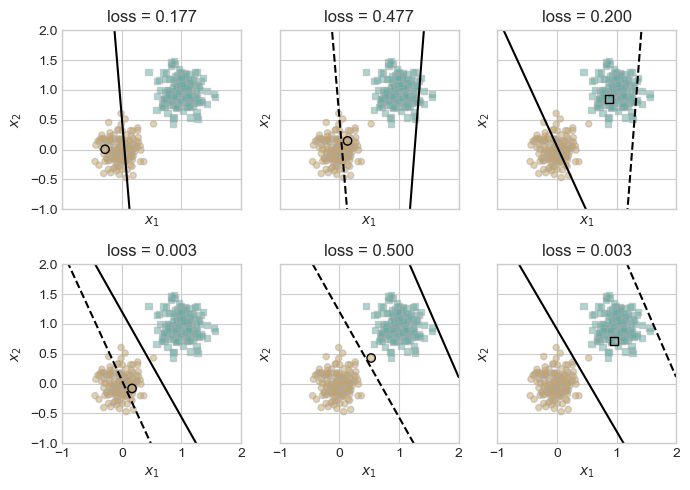

In [4]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    
    # Making sure we don't run out of axes
    if current_ax >= len(axarr.ravel()):
        print("Ran out of axes to plot. Stopping early.")
        break
    
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)
    

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        opt.step(x_i, y_i)
    
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

The figure shows a step-by-step visualization of the oerceptron learning process over six weight updates. Each subplot displays the current decision boundary as a solid line. The loss values does decrease from 0.177 to 0.003 but throughout iterations there are many fluctuations such as the spike back to 0.500 in the fifth plot show that a single-point update can temporarily worsen performance on the full dataset. 

## Experiment 2

In [5]:
# Create non-linearly separable data
X, y = perceptron_data(n_points = 300, noise = 0.5)
n = X.size(0)

Generates a new dataset with higher noise, making it non-linearly separable, to test the perceptron's performance in a more challenging scenario.

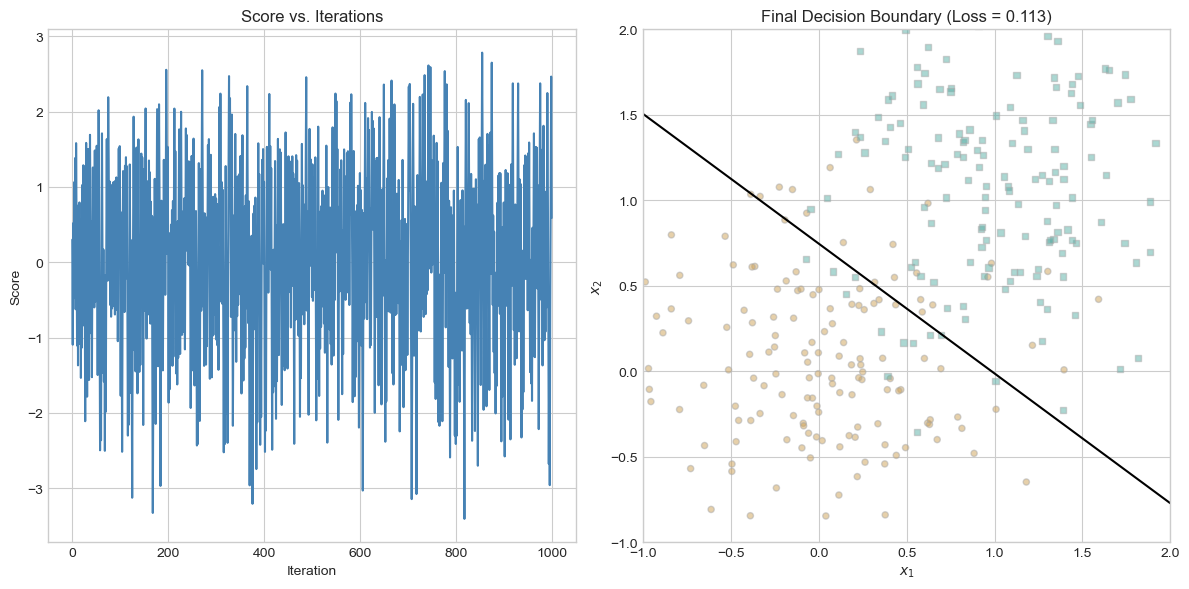

In [6]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
current_ax = 0

loss = 1
score_vec = [] 

while loss > 0 and len(score_vec) <= 1000:

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)
    
    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    score = p.score(X).mean()

    if local_loss > 0:
        opt.step(x_i, y_i)
    
    if local_loss > 0:
        loss = p.loss(X, y).item()
        score = p.score(X).mean()
        score_vec.append(score)

# plot the score over iterations
axarr[0].plot(range(len(score_vec)), score_vec, color="steelblue", label="Score")
axarr[0].set_title("Score vs. Iterations")
axarr[0].set_xlabel("Iteration")
axarr[0].set_ylabel("Score")

# Plot the final decision boundary
plot_perceptron_data(X, y, axarr[1])
draw_line(p.w, x_min=-1, x_max=2, ax=axarr[1], color="black")
axarr[1].set_title(f"Final Decision Boundary (Loss = {loss:.3f})")
axarr[1].set(xlim=(-1, 2), ylim=(-1, 2))

plt.tight_layout()


Trains the perceptron on the non-linearly separable data, tracking the model's score (accuracy) over iterations. It plots both the score progression and the final decision boundary, illustrating the perceptron's limitations on such data. The left plot shows the score  across 1,000 iterations. The values fluctuate heavily and the model is unable to consistent accurate score. The right plot shows the final decision boundary with a loss of 0.113. While the boundary generally separates the two classes, several misclassified points remain, particularly near the overlap region. The model was unable to achieve lowest accuracy before 1000 iterations, highlighting it's difficulty to converge. 

## Experiment 3

In [7]:
X, y = perceptron_data(n_points = 300, noise = 0.2, p_dims=5)

Generates a new dataset with five features (higher dimensionality) to test how the perceptron performs in higher-dimensional spaces.

In [8]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss = 1
score_vec = [] 

while loss > 0 and len(score_vec) <= 1000:

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)
    
    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    prev_length = len(score_vec)
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    score = p.score(X).mean()

    if local_loss > 0:
        opt.step(x_i, y_i)
    
    if local_loss > 0:
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        score = p.score(X).mean()
        score_vec.append(score)
    
    if(len(score_vec) != prev_length):
        print(f"Iteration {len(score_vec)}: Loss = {loss:.3f}, Score = {score:.3f}")

Iteration 1: Loss = 0.010, Score = 0.625
Iteration 2: Loss = 0.000, Score = -0.486


The perceptron converged in just two updates, indicating that the dataset is linearly separable. In the first iteration, the loss dropped to 0.010 with a score of 0.625, reflecting improved separation. After the second update, the loss reached 0.000, meaning all training points were correctly classified. Interestingly, the score dropped to -0.486 despite perfect classification. This occurs because the score reflects the signed margin, not accuracy, and can decrease if the update alters the orientation or scale of the decision boundary. Overall, the perceptron successfully found a separating hyperplane in minimal steps.

The runtime complexity of a single iteration of the perceptron algorithm is O(p), where p is the number of features. This is because each update involves computing the dot product between the weight vector and a single data point, which requires iterating over p elements. The complexity does not depend on the number of data points n in a single iteration, since each iteration operates on only one randomly selected point. For a single iteration, the cost is linear in the number of features and independent of the dataset size.


## Minibatch Perceptron

In [9]:
def plot_perceptron_training(X: torch.Tensor, y: torch.Tensor, model, optimizer, k: int = 0, 
                             max_iters: int = 1000, alpha: float =  0.1):

    # Initialize model and optimizer
    p = model()
    opt = optimizer(p)
    p.loss(X, y)

    fig, axarr = plt.subplots(1, 3, figsize=(18, 6))

    loss = 1
    loss_vec = []
    score_vec = []

    iteration = 0

    while loss > 0 and iteration <= max_iters:

        if k == 0:
            i = torch.randint(X.size(0), size=(1,))
            x_i = X[[i],:]
            y_i = y[i]
        else:
            ix = torch.randperm(X.size(0))[:k]
            x_i = X[ix,:]
            y_i = y[ix]

        local_loss = p.loss(x_i, y_i).item()
        score = p.score(X).mean()

        if local_loss > 0:
            if k == 0:
                opt.step(x_i, y_i)
            else:
                opt.step(x_i, y_i, alpha=alpha, mini_batch = True)

            loss = p.loss(X, y).item()
            loss_vec.append(loss)
            score_vec.append(score)

        iteration += 1

    # Plot score over iterations
    axarr[0].plot(range(len(score_vec)), score_vec, color="steelblue", label="Score")
    axarr[0].set_title("Score vs. Iterations")
    axarr[0].set_xlabel("Iteration")
    axarr[0].set_ylabel("Score")

    # Plot loss over iterations
    axarr[1].plot(range(len(loss_vec)), loss_vec, color="steelblue", label="Loss")
    axarr[1].set_title("Loss vs. Iterations")
    axarr[1].set_xlabel("Iteration")
    axarr[1].set_ylabel("Loss")

    # Plot final decision boundary
    plot_perceptron_data(X, y, axarr[2])
    draw_line(p.w, x_min=-1, x_max=2, ax=axarr[2], color="black")
    axarr[2].set_title(f"Final Decision Boundary (Loss = {loss:.3f})")
    axarr[2].set(xlim=(-1, 2), ylim=(-1, 2))

    plt.tight_layout()
    plt.show()


### Experiment 1: k = 1

In [10]:
torch.manual_seed(1234567)
X, y = perceptron_data(n_points = 300, noise = 0.2, p_dims=2)

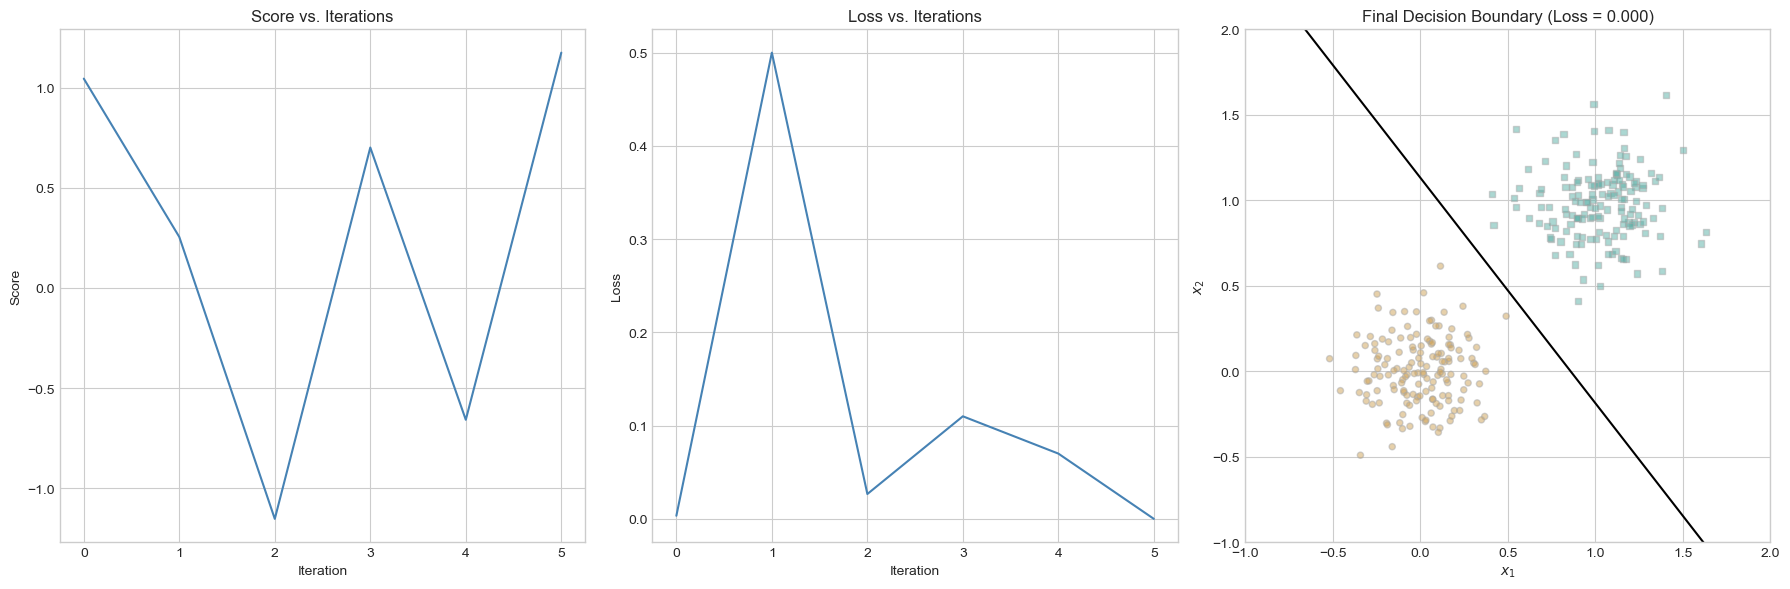

In [11]:
# Regualar Perceptron
plot_perceptron_training(X, y, Perceptron, PerceptronOptimizer)

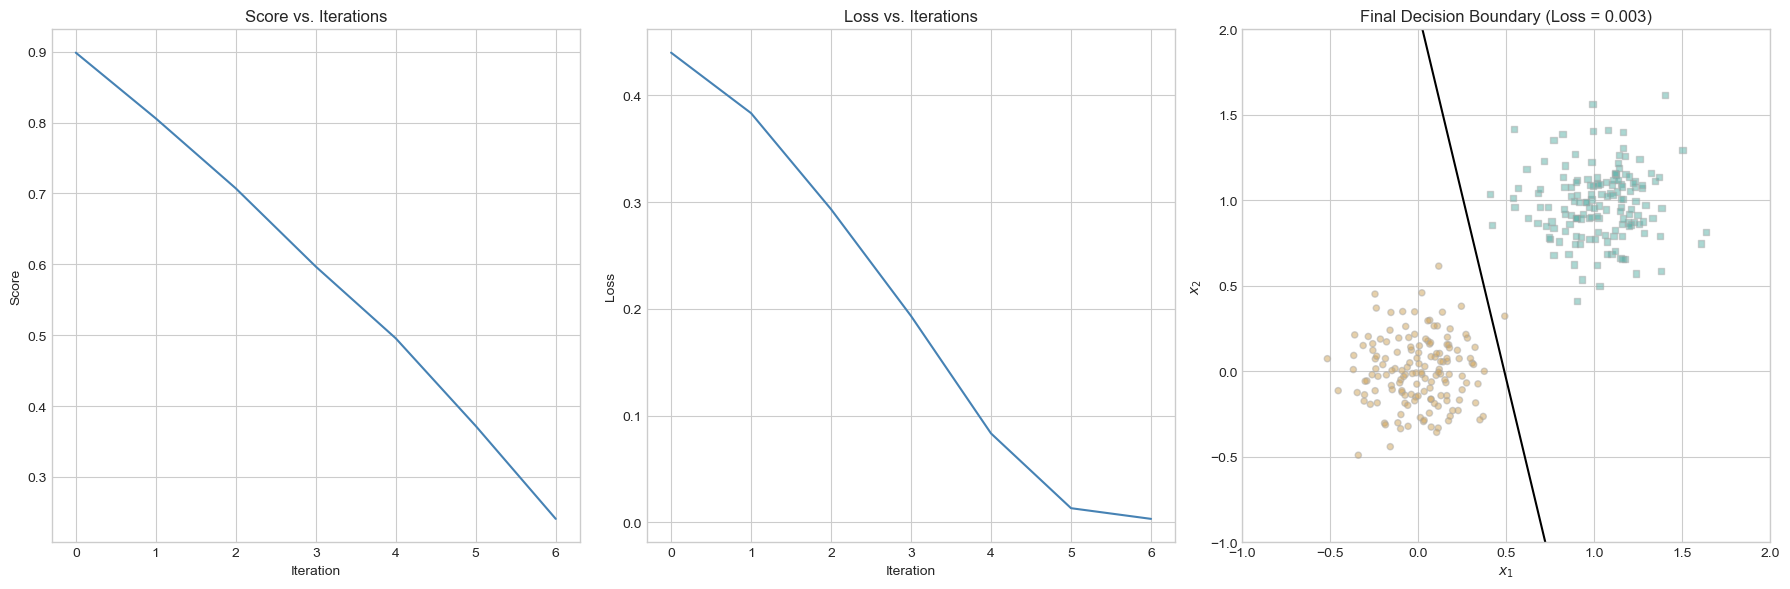

In [12]:
# Mini-batch k = 1
plot_perceptron_training(X, y, Perceptron, PerceptronOptimizer, k=1)

### Experiment 2: k = 10

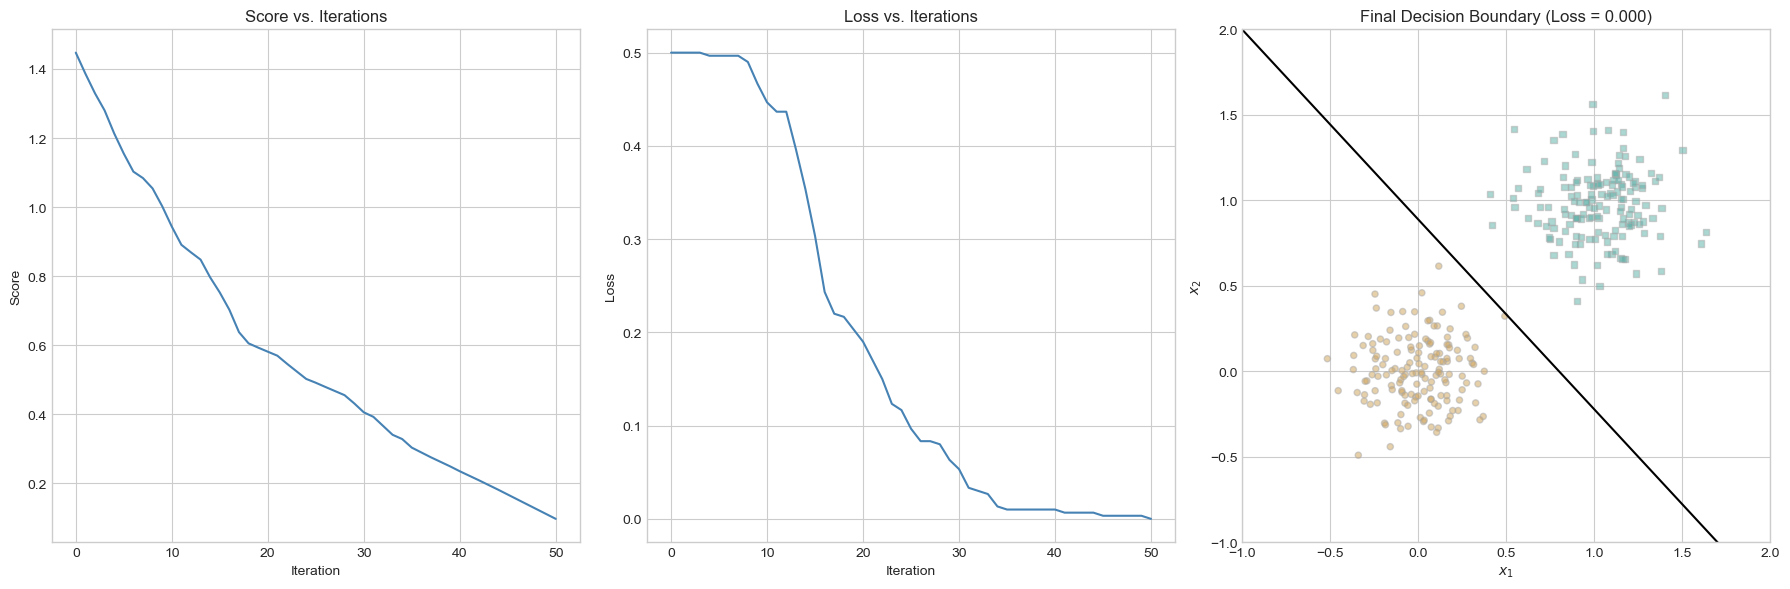

In [13]:
plot_perceptron_training(X, y, Perceptron, PerceptronOptimizer, k=10)

### Experiment 3: k = n

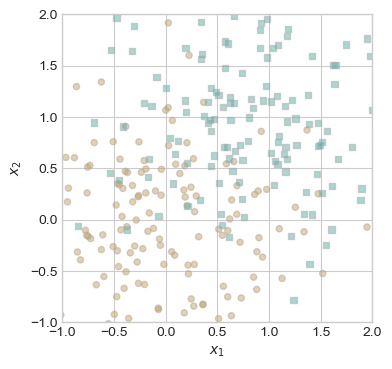

In [14]:
# Create non-linearly separable data
X, y = perceptron_data(n_points = 300, noise = 0.7, p_dims=2)
n = X.size(0)

# Plot the non-linearly separable data
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)


In [ ]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

fig, axarr = plt.subplots(1, 2, figsize=(12, 6))

loss = 1
loss_vec = [] 
k = n

while loss > 0:
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    local_loss = p.loss(x_i, y_i).item()
    score = p.score(X).mean()

    if local_loss > 0:
        opt.step(x_i, y_i, alpha=0.0001, mini_batch = True)
    
    if local_loss > 0:
        loss = p.loss(X, y).item()
        score = p.score(X).mean()
        score_vec.append(score)
        loss_vec.append(loss)

# plot the loss over iterations
axarr[0].plot(range(len(loss_vec)), loss_vec, color="steelblue", label="Loss")
axarr[0].set_title("Loss vs. Iterations")
axarr[0].set_xlabel("Iteration")
axarr[0].set_ylabel("Loss")

# Plot the final decision boundary
plot_perceptron_data(X, y, axarr[1])
draw_line(p.w, x_min=-1, x_max=2, ax=axarr[1], color="black")
axarr[1].set_title(f"Final Decision Boundary (Loss = {loss:.3f})")
axarr[1].set(xlim=(-1, 2), ylim=(-1, 2))

plt.tight_layout()

## Conclusion

The experiments demonstrate that the perceptron algorithm can efficiently converge to a zero-loss solution when the data is linearly separable, often requiring very few updates. Visualizations confirm that the decision boundary evolves meaningfully with each iteration. However, when the data is non-linearly separable, the algorithm fails to reach zero loss, and its score fluctuates unpredictably, highlighting its limitations in such cases.